# Summary

&emsp; This notebook contains code to compare the performance of different models used to classify upper limb gestures from EMG recordings. Specifically, I compare within and across-subject performance between a logisitc regression model and Recursive Neural Network (RNN) model. Overall, I find that both models have high level of performance when the test data comes from the same subject on which the model was trained (**within-subject performance**). In contrast, classification performance substantially drops when the test data comes from a different subject(**across-subject performance**)

The following notebooks in this repo contain useful data and analysis pipeline details:
- data_exploration_and_quality_check_demo.ipynb
- single_subject_classification_demo.ipynb

The following notebooks contain the code used to assess model performance and write the results to hdf5 files.
- get_log_regression_performance_within_and_across_subjects.ipynb
- get_RNN_regression_performance_within_and_across_subjects.ipynb

In [1]:
#import necessary packages

#our workhorses
import numpy as np
import pandas as pd
import scipy

#to visualize
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#style params for figures
sns.set(font_scale = 2)
plt.style.use('seaborn-white')
plt.rc("axes", labelweight="bold")
from IPython.display import display, HTML

#to load files
import os
import h5py

#for stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multitest as multitest
import statsmodels.stats.multicomp

#load custon functions
from utils import *


### Load Data Files

&emsp; The code blocks below load the dataframes with within and across subject performance results and output brief summaries of the data. All data files contain results for shuffled and unshuffled data to compare observed performance with performance with uninformative data (null distribution).

In [2]:
# Load logistic regression within-subject data

results_folder = './results_data/log_reg'
results_fn = 'all_subjects_within_subject_results.h5'
lr_results_df = pd.read_hdf(os.path.join(results_folder,results_fn), 'results_df')


# Average over multiple train/test splits of the data
lr_results_df = lr_results_df.groupby(['Shuffled','Type','Train_Subject','Test_Subject'],as_index = False)\
.mean()\
.drop(columns = ['Fold','Rep'])


# Output summary
display(HTML(lr_results_df.groupby(['Shuffled','Type']).mean().drop(columns = ['Train_Subject','Test_Subject']).to_html()))


In [3]:
# Load logistic regression across-subject data

results_folder = './results_data/log_reg'
results_fn = 'all_subjects_across_subject_results.h5'
lr_xsubj_results_df = pd.read_hdf(os.path.join(results_folder,results_fn), 'results_df')


# Average over test subjects
lr_xsubj_results_df = lr_xsubj_results_df.groupby(['Shuffled','Type','Train_Subject'],as_index = False)\
.mean()\
.drop(columns = ['Test_Subject'])

# Output summary
display(HTML(lr_xsubj_results_df.groupby(['Shuffled','Type']).mean().drop(columns = ['Train_Subject']).to_html()))


,,F1_score
Shuffled,Type,
False,Test,0.561763
True,Test,0.144078


In [4]:
# Combine logistic regression results in a single data frame and label

# keep test scores only
lr_results_df = lr_results_df.loc[lr_results_df.Type=='Test']
#drop test subject column
lr_results_df = lr_results_df.drop(columns = ['Test_Subject'])
# label
lr_results_df['Test_Type'] = 'Within_Subject'
lr_xsubj_results_df['Test_Type'] = 'Across_Subject'

#combine
lr_combo_results_df = pd.concat([lr_results_df,lr_xsubj_results_df],axis = 0)

#label
lr_combo_results_df['Model'] = 'Log_reg'

In [5]:
# Load RNN within-subject data
nsubjects = 36

rnn_results_df = [] 

results_folder = './results_data/RNN'
for src_subject_id in range(1,nsubjects+1):
    results_fn = 'subject_%02d_within_subject_results.h5'%(src_subject_id)
    subject_df = pd.read_hdf(os.path.join(results_folder,results_fn), 'results_df')
    subject_df['Train_Subject'] = src_subject_id
    subject_df['Test_Subject'] = src_subject_id
    rnn_results_df.append(subject_df)

rnn_results_df = pd.concat(rnn_results_df,axis = 0)

# Average over multiple train/test splits of the data
rnn_results_df = rnn_results_df.groupby(['Shuffled','Type','Train_Subject','Test_Subject'],as_index = False)\
.mean()\
.drop(columns = ['Fold','Rep'])

# Output summary
display(HTML(rnn_results_df.groupby(['Shuffled','Type']).mean().drop(columns = ['Train_Subject','Test_Subject']).to_html()))

In [6]:
# Load RNN across-subject data
nsubjects = 36

rnn_xsubj_results_df = [] 

results_folder = './results_data/RNN'
for src_subject_id in range(1,nsubjects+1):
    results_fn = 'subject_%02d_across_subject_results.h5'%(src_subject_id)
    subject_df = pd.read_hdf(os.path.join(results_folder,results_fn), 'results_df')
    rnn_xsubj_results_df.append(subject_df)

rnn_xsubj_df = pd.concat(rnn_xsubj_results_df,axis = 0)

# Average over test subjects
rnn_xsubj_df = rnn_xsubj_df.groupby(['Shuffled','Type','Train_Subject'],as_index = False)\
.mean()\
.drop(columns = ['Test_Subject','Rep'])

# Output summary
display(HTML(rnn_xsubj_df.groupby(['Shuffled','Type']).mean().drop(columns = ['Train_Subject']).to_html()))



In [7]:
# Combine RNN results in a single dataframe and label

# keep test scores only
rnn_results_df = rnn_results_df.loc[rnn_results_df.Type=='Test']
rnn_xsubj_df = rnn_xsubj_df.loc[rnn_xsubj_df.Type == 'Test']
#drop test subject column
rnn_results_df = rnn_results_df.drop(columns = ['Test_Subject'])
# label
rnn_results_df['Test_Type'] = 'Within_Subject'
rnn_xsubj_df['Test_Type'] = 'Across_Subject'

#combine
rnn_combo_results_df = pd.concat([rnn_results_df,rnn_xsubj_df],axis = 0)


rnn_combo_results_df['Model'] = 'RNN'

## Visualize and Compare Results

&emsp; The code blocks below visualize within and across-subject performance for both the logisitc regression and RNN model. Addittionally, I run a two-factor ANOVA to test for differences in model performance within and across subjects.

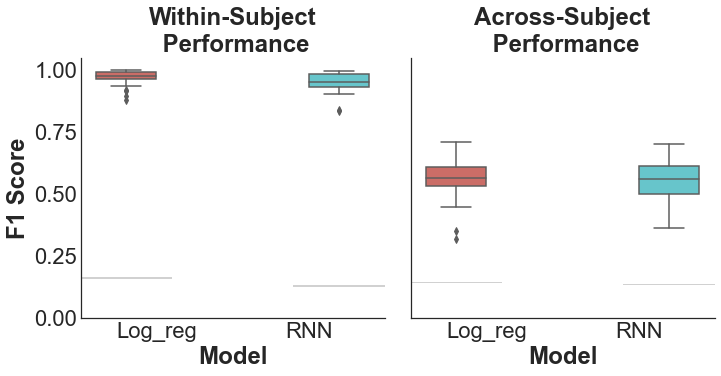

In [8]:
# Combine results across subjects
all_model_combo_df = pd.concat([rnn_combo_results_df,lr_combo_results_df], axis = 0)

# Separate results with shuffled and unshuffled data
true_results_df = all_model_combo_df.loc[all_model_combo_df.Shuffled==False]
shuffled_results_df = all_model_combo_df.loc[all_model_combo_df.Shuffled==True]


# Get confidence interval for shuffled data results
model_list = ['Log_reg','RNN']
type_list = ['Within_Subject','Across_Subject']
null_ci = np.zeros((2,2,2))

for i,m in enumerate(model_list):
    for j,t in enumerate(type_list):
        null_df = shuffled_results_df.loc[(shuffled_results_df.Model==m)&(shuffled_results_df.Test_Type==t)]
        null_ci[j,i,:] = sns.utils.ci(sns.algorithms.bootstrap(null_df['F1_score'].values))


#Visualize unshuffled data results
sns.set_palette(sns.color_palette("hls", 2))
g = sns.catplot(data = true_results_df, x= 'Model', y = 'F1_score', col = 'Test_Type', hue = 'Model',\
            kind = 'box', order = ['Log_reg','RNN'], hue_order = ['Log_reg','RNN'])

#Label axes and subpots, mark chance confidence interval
for i,ax in enumerate(g.axes[0]):
    ax.set_xlabel('Model')
    ax.set_ylim([0,1.05])
    ax.add_patch(patches.Rectangle((-.5, null_ci[i,0,0]), 0.6, (null_ci[i,0,1]-null_ci[i,0,0]),\
                                         linewidth=0, fill=True, color='k', alpha=0.2))
    ax.add_patch(patches.Rectangle((.9, null_ci[i,1,0]), 0.6, (null_ci[i,1,1]-null_ci[i,1,0]),\
                                         linewidth=0, fill=True, color='k', alpha=0.2))



g.axes[0][0].set_ylabel('F1 Score')
g.axes[0][0].set_title('Within-Subject\n Performance',fontweight = 'bold');
g.axes[0][1].set_title('Across-Subject\n Performance',fontweight = 'bold');

plt.gcf().suptitle('', y = 1.05, fontweight = 'bold');

In [9]:
# Output Summary
true_results_df.groupby(['Test_Type','Model']).mean().drop(columns=['Shuffled','Train_Subject'])

F1_score
Test_Type      Model            
Across_Subject Log_reg  0.561763
               RNN      0.556615
Within_Subject Log_reg  0.969033
               RNN      0.951251

In [10]:
# Run 2-factor ANOVA
model = ols('F1_score ~ C(Test_Type)*C(Model)', true_results_df).fit()

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

,sum_sq,df,F,PR(>F)
C(Test_Type),5.787472,1.0,1417.498321,4.048395e-75
C(Model),0.004732,1.0,1.158888,2.835478e-01
C(Test_Type):C(Model),0.001437,1.0,0.351888,5.540036e-01
Residual,0.571603,140.0,NaN,NaN


#### Conclusion
&emsp; The results above show that classification performance for both the logisitc regression and RNN model drops when the test data comes from a subject different than that used to train the model. However, performance for both models still remains quite distinct from performance with shuffled data so there is some degree of generalization across subjects. A two-factor ANOVA showed only an effect of test type (p<.001), no effect of model (p = .28) and no interaction between these two factors (p=.55). From this, I can conclude that the performance of both models was similar for within and across subject classification.


Overall, I conclude from this that neither model does a good job of transferring the callibration learned from one subject to another subject. There could be many reasons for this including different positioning of the electrodes across subjects and difference in the physiological signals across subjects. The source of this variability is beyond this project. For the next stage, I focus on comparing different strategies to transfer model callibration across subjects.